In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, log_loss, confusion_matrix
from sklearn.utils import class_weight

import os
import io
import warnings
warnings.filterwarnings('ignore')

In [3]:
#pip install missingno

# Our dataset 🧐

In [4]:
dataset = pd.read_csv("/content/drive/MyDrive/Data /JEDHA/Fullstack/deep_learning/spam_detector_project/spam.csv", encoding="latin1")
dataset.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [5]:
dataset.shape

(5572, 5)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


 Missing values

In [7]:
# missing values percentage
dataset.isnull().sum()/dataset.shape[0]*100

,0
v1,0.000000
v2,0.000000
Unnamed: 2,99.102656
Unnamed: 3,99.784637
Unnamed: 4,99.892319


<Axes: >

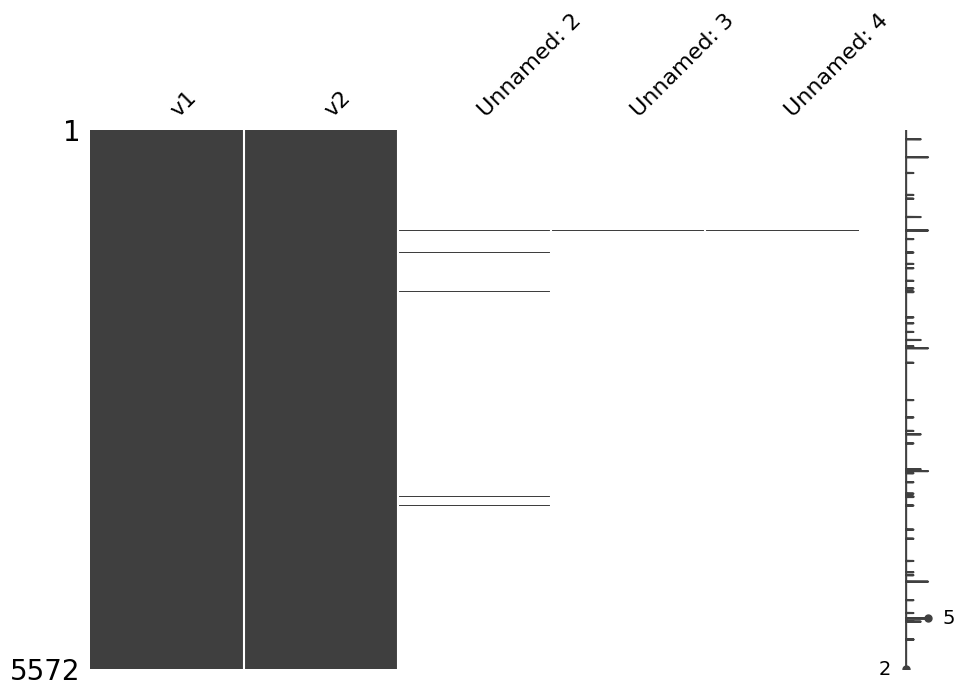

In [8]:
# missing values viz
msno.matrix(dataset, figsize = (11,7))

In [9]:
# Let's explore those rows where [Unnamed: 2","Unnamed: 3","Unnamed: 4"] have values
subset_columns =["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
filtered_df = dataset.dropna(subset=subset_columns, how='all')

filtered_df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve.."""
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)"""
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN


In [10]:
# Let's concatenate to get full texts (filtered_df shows that some messages are split) #

column_names = ['v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

# Fill missing values in the columns with empty strings and concatenate
dataset['full_messages'] = ''
for col in column_names:
    dataset['full_messages'] += ' ' + dataset[col].fillna('')


In [11]:
# Let's take a look
dataset[dataset['Unnamed: 2'].isna()==False].head(15)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,full_messages
95,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN,Your free ringtone is waiting to be collected...
281,ham,\Wen u miss someone,the person is definitely special for u..... B...,why to miss them,"just Keep-in-touch\"" gdeve..""",\Wen u miss someone the person is definitely...
444,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...,NaN,NaN,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYA...
671,spam,SMS. ac sun0819 posts HELLO:\You seem cool,"wanted to say hi. HI!!!\"" Stop? Send STOP to ...",NaN,NaN,SMS. ac sun0819 posts HELLO:\You seem cool w...
710,ham,Height of Confidence: All the Aeronautics prof...,"this wont even start........ Datz confidence..""",NaN,NaN,Height of Confidence: All the Aeronautics pro...
899,spam,Your free ringtone is waiting to be collected....,PO Box 5249,"MK17 92H. 450Ppw 16""",NaN,Your free ringtone is waiting to be collected...
1038,ham,"Edison has rightly said, \A fool can ask more ...",GN,GE,"GNT:-)""","Edison has rightly said, \A fool can ask more..."
1127,ham,"Height of \Oh shit....!!\"" situation: A guy th...",".;-):-D""",NaN,NaN,"Height of \Oh shit....!!\"" situation: A guy t..."
1266,ham,\Hey sorry I didntgive ya a a bellearlier hunny,just been in bedbut mite go 2 thepub l8tr if u...,NaN,NaN,\Hey sorry I didntgive ya a a bellearlier hun...
1384,ham,"Storming msg: Wen u lift d phne, u say \HELLO\...","bt not his girlfrnd... G o o d n i g h t . . .@""",NaN,NaN,"Storming msg: Wen u lift d phne, u say \HELLO..."


In [12]:
# creating dataframe with v1, full_message columns
spam_df = dataset[['v1', 'full_messages']]

# renaming column v1 to 'labels'
spam_df.rename(columns={"v1" : "labels"}, inplace=True)

spam_df.head()

,labels,full_messages
0,ham,"Go until jurong point, crazy.. Available only..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fin...
3,ham,U dun say so early hor... U c already then sa...
4,ham,"Nah I don't think he goes to usf, he lives ar..."


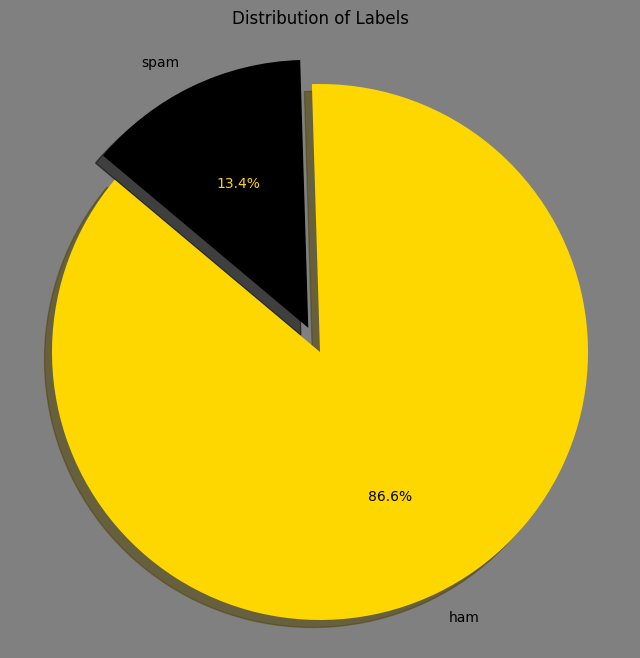

In [13]:
# target distribution
label_counts = spam_df['labels'].value_counts()

plt.figure(figsize=(8, 8), facecolor = "grey")
patches, texts, autotexts  = plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors = ["gold", "black"], explode=(0.1, 0), shadow=True)
autotexts[1].set_color('gold')
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

# **Preprocessing** 🛠

In [14]:
# let's make sure that all the messages are in string type
mask_str = spam_df["full_messages"].apply(lambda x: isinstance(x, str))
print("Percentage of strings in column below is: ")
mask_str.value_counts()/spam_df.shape[0]*100

Percentage of strings in column below is: 


,count
full_messages,
True,100.0


In [15]:
# spaCy Medium English language model
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [16]:
# Import Spacy and English initialisation
import en_core_web_md
nlp = en_core_web_md.load()


In [17]:
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

Cleaning texts🧹

In [18]:
# remove all characters from messages that are not alphanumeric except for whitespaces, and apostrophies.
spam_df["messages_clean"] = spam_df["full_messages"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))

# replace double whitespaces or more with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces.
spam_df["messages_clean"] = spam_df["messages_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

# replace all tokens with lemma_ and remove all the stop words.
spam_df["messages_clean"] = spam_df["messages_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

spam_df.head()

,labels,full_messages,messages_clean
0,ham,"Go until jurong point, crazy.. Available only...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fin...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then sa...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives ar...",nah think usf live


In [19]:
# let's make sure that no message has been erased
spam_df.isnull().sum()

,0
labels,0
full_messages,0
messages_clean,0


In [20]:
# let's encode the messages
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab")
tokenizer.fit_on_texts(spam_df.messages_clean)
spam_df["messages_encoded"] = tokenizer.texts_to_sequences(spam_df.messages_clean)

In [ ]:
spam_df.head()

,labels,full_messages,messages_clean,messages_encoded
0,ham,"Go until jurong point, crazy.. Available only...",jurong point crazy available bugis n great wor...,"[1, 235, 448, 463, 943, 32, 51, 209, 944, 78, ..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[9, 196, 464, 291, 2, 1]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fin...,free entry 2 wkly comp win fa cup final tkts 2...,"[11, 302, 3, 531, 660, 30, 1, 850, 425, 1, 1, ..."
3,ham,U dun say so early hor... U c already then sa...,u dun early hor u c,"[2, 126, 150, 1, 2, 80]"
4,ham,"Nah I don't think he goes to usf, he lives ar...",nah think usf live,"[708, 20, 661, 131]"


In [21]:
spam_df.shape

(5572, 4)

In [22]:
# Let's convert our categorical labels into numerical format using a label encoder
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(spam_df.labels)

In [23]:
# before creating a tensor dataset we will pad the sequences so that they have the same length
messages_pad = tf.keras.preprocessing.sequence.pad_sequences(spam_df.messages_encoded, padding="post")
messages_pad

array([[  1, 235, 448, ...,   0,   0,   0],
       [  9, 196, 464, ...,   0,   0,   0],
       [ 11, 302,   3, ...,   0,   0,   0],
       ...,
       [  1, 939,   1, ...,   0,   0,   0],
       [114,   1,   1, ...,   0,   0,   0],
       [  1, 314,   0, ...,   0,   0,   0]], dtype=int32)

Split train / Val 🪓

In [24]:
xtrain, xval, ytrain, yval = train_test_split(messages_pad, encoded_labels, test_size= 0.3, stratify= encoded_labels) # Since we have unbalanced target distribution we stratify (we'll consider data augmentation for example later)

In [25]:
# Let's create the tensor dataset for the training and validation set
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

In [26]:
# Now let's shuffle and organize by batch
train_batch = train.shuffle(len(train)).batch(32)
val_batch = val.shuffle(len(val)).batch(32)

In [27]:
# we take a look at one batch
for batch in train_batch.take(1):
  print(batch)

(<tf.Tensor: shape=(32, 74), dtype=int32, numpy=
array([[396, 256,   1, ...,   0,   0,   0],
       [  1, 128,   1, ...,   0,   0,   0],
       [  1, 894,   1, ...,   0,   0,   0],
       ...,
       [607,  54,   1, ...,   0,   0,   0],
       [ 74,   7,  89, ...,   0,   0,   0],
       [ 20,   1, 450, ...,   0,   0,   0]], dtype=int32)>, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0])>)


In [28]:
train_batch.element_spec[0].shape[1]


74

## ***Let's dive in*** 🤿



In [29]:
# Firts we create a function that returns metrics to evaluate our models. That will help to make a comparison later
def evaluate_model(model, y_true, y_pred):


  y_pred = np.round(model.predict(y_pred))
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1_score = f1_score(y_true, y_pred)
  loss = loss(y_true, y_pred)

  metrics_dict = {
      'model': model,
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score': f1_score,
      'loss': loss
    }
  return metrics_dict

In [30]:
# We also create a function that returs a confusion matrix for each model
def generate_confusion_matrix(model_name, y_true, y_pred, labels=None):

    cm = confusion_matrix(y_true, y_pred, labels= model_we.classes_)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Word Embedding


## Modeling 👩‍🔧

In [31]:
vocab_size = tokenizer.num_words

model_we = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 8, input_shape = (train_batch.element_spec[0].shape[1],), name = "embedding"),

    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(16, activation = 'relu'),

    tf.keras.layers.Dense(1, activation = 'sigmoid')

])

In [32]:
model_we.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 74, 8)               │           8,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,169 (31.91 KB)

 Trainable params: 8,169 (31.91 KB)

 Non-trainable params: 0 (0.00 B)

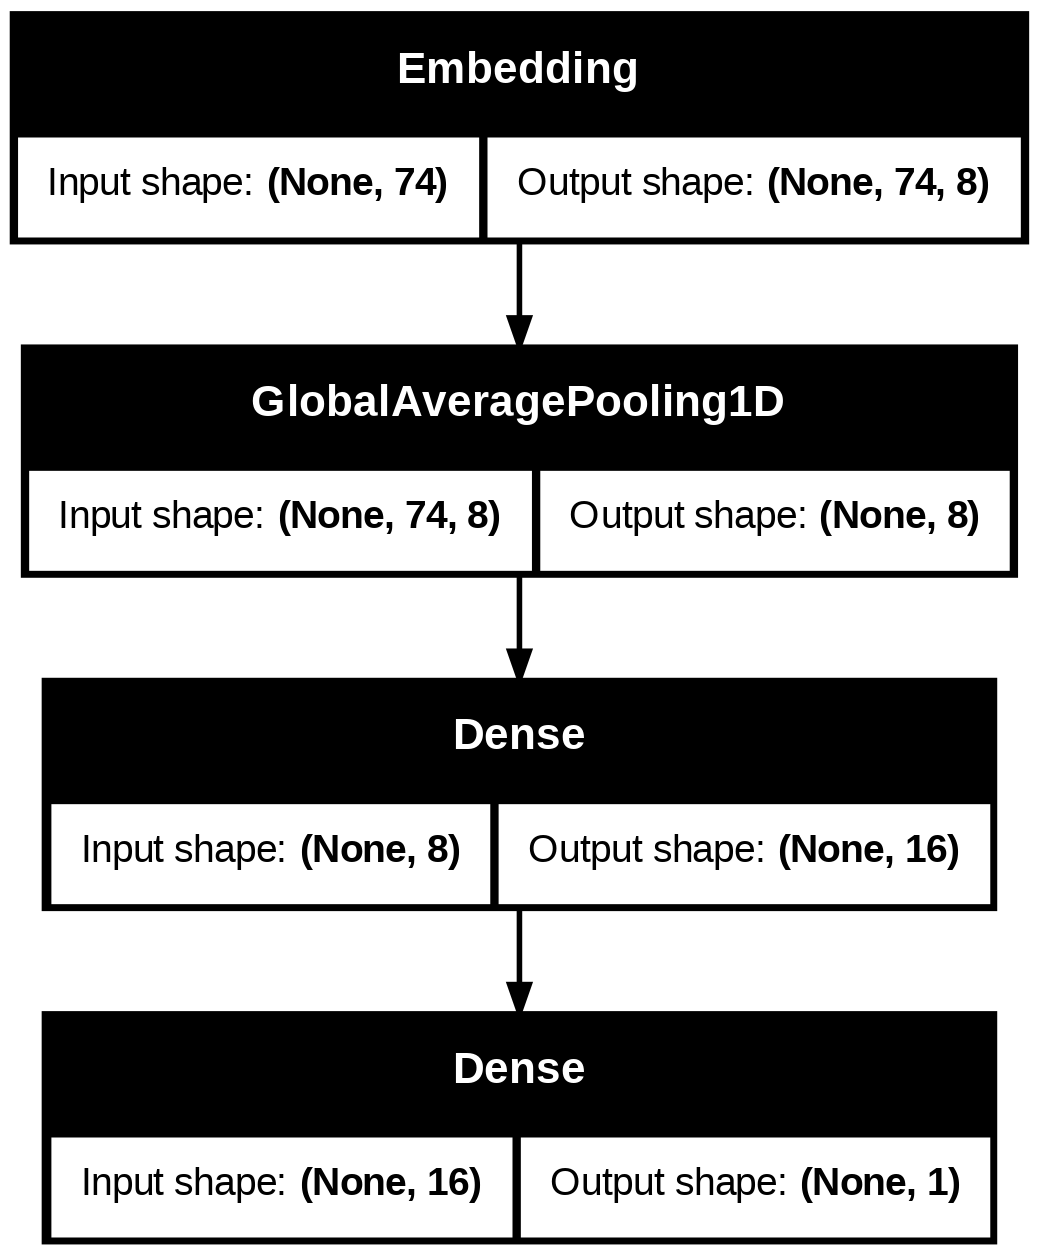

In [33]:
#Plot model
tf.keras.utils.plot_model(model_we, show_shapes=True)

In [34]:
# Compile model
model_we.compile(optimizer = 'adam',
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'] #'precision', 'recall', 'f1_score', 'auc']
                 )

## Training 🤿🏃‍♀️

In [35]:
history_we = model_we.fit(train_batch,
                       epochs=50,
                       validation_data = val_batch)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8702 - loss: 0.4278 - val_accuracy: 0.8660 - val_loss: 0.3631
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8745 - loss: 0.3436 - val_accuracy: 0.8660 - val_loss: 0.3532
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8669 - loss: 0.3464 - val_accuracy: 0.8660 - val_loss: 0.3401
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8638 - loss: 0.3349 - val_accuracy: 0.8660 - val_loss: 0.3226
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8675 - loss: 0.3056 - val_accuracy: 0.8660 - val_loss: 0.2955
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8630 - loss: 0.2876 - val_accuracy: 0.8780 - val_loss: 0.2630
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8756 - loss: 0.2629 - val_accuracy: 0.8900 - val_loss: 0.2390
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8995 - loss: 0.2273 - val_accuracy: 0

## Evaluation 🕵️‍♀️

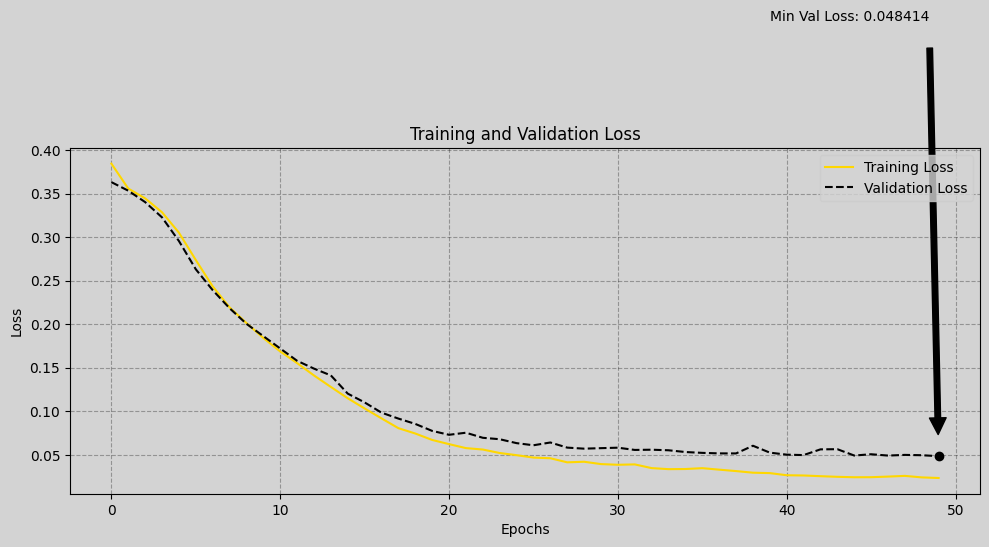

In [36]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor='lightgrey')
ax.set_facecolor('lightgrey')

ax.plot(history_we.history["loss"], label="Training Loss", color="gold", linestyle="-")
ax.plot(history_we.history["val_loss"], label="Validation Loss", color="black", linestyle="--")

ax.set_title("Training and Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax.grid(True, linestyle='--', alpha=0.3, color='black')

min_val_loss = min(history_we.history["val_loss"])
min_val_loss_epoch = history_we.history["val_loss"].index(min_val_loss)
ax.annotate(f'Min Val Loss: {min_val_loss:f}',
             xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch-10, min_val_loss+0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax.scatter(min_val_loss_epoch, min_val_loss, color='black', marker='o')

legend = ax.legend(loc='upper right', frameon=True)
legend.get_frame().set_facecolor('lightgrey')

# Show plot
plt.tight_layout()
plt.show()


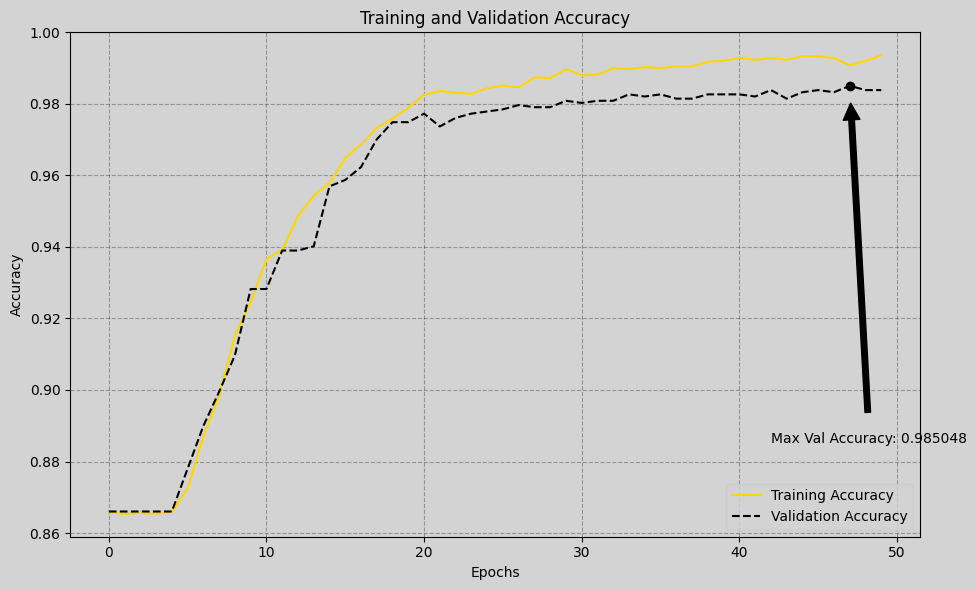

In [38]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor='lightgrey')
ax.set_facecolor('lightgrey')

ax.plot(history_we.history["accuracy"], label="Training Accuracy", color="gold", linestyle="-")
ax.plot(history_we.history["val_accuracy"], label="Validation Accuracy", color="black", linestyle="--")

ax.set_title("Training and Validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()

ax.grid(True, linestyle='--', alpha=0.3, color='black')

max_val_acc = max(history_we.history["val_accuracy"])
max_val_acc_epoch = history_we.history["val_accuracy"].index(max_val_acc)
ax.annotate(f'Max Val Accuracy: {max_val_acc:f}',
             xy=(max_val_acc_epoch, max_val_acc),
             xytext=(max_val_acc_epoch-5, max_val_acc-0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax.scatter(max_val_acc_epoch, max_val_acc, color='black', marker='o')

legend = ax.legend(loc='lower right', frameon=True)
legend.get_frame().set_facecolor('lightgrey')

plt.tight_layout()
plt.show()

Let's test our model on 10 spams and 10 HAM ! 🤓

In [39]:
messages_received = [
    "Congratulations! You've won a luxury vacation package to the Bahamas! Claim your prize now by clicking the link below!", #fake
    "Urgent: Your account security has been compromised! Please verify your identity by logging in to your account immediately.", #fake
    "Hi there! Just wanted to check in and see how you're doing. Let's catch up soon!",
    "Limited time offer: Get 50% off on all weight loss supplements! Shed those extra pounds fast!",#fake
    "Reminder: Don't forget about our team meeting tomorrow at 10 AM in the conference room.",
    "Hey, did you hear about the new coffee shop that opened downtown? We should check it out sometime!",
    "Thanks for sending over the report. I'll review it and get back to you with any feedback.",
    "You've been selected for a once-in-a-lifetime investment opportunity! Earn guaranteed returns with minimal risk!", #fake
    "Act now and receive a free trial of our revolutionary skincare product! Say goodbye to wrinkles and blemishes!", #fake
    "Good morning! Wishing you a wonderful day ahead filled with positivity and productivity.",
    "Your Amazon account has been suspended! Please update your payment information to avoid permanent closure.", #fake
    "Hi Ellie, I wanted to share this interesting article I came across. I think you'll find it insightful.",
    "Happy birthday! I hope your special day is filled with joy, laughter, and lots of cake!",
    "Need cash fast? Get a payday loan approved instantly with no credit check required!", #fake
    "Just a heads up, there's heavy traffic on your usual route to work. You might want to consider taking an alternate route.",
    "Congratulations! You've been chosen as our lucky winner for a brand new iPhone! Click the link to claim your prize.", #fake
    "Get rich quick! Join our exclusive affiliate marketing program and start earning passive income today!", #fake
    "Attention: Your computer is infected with a virus! Download our antivirus software now to protect your data.", #fake
    "Great job on completing the project ahead of schedule! Your hard work and dedication are truly appreciated.",
    "Hey, are you free this weekend? I was thinking we could go hiking and enjoy the beautiful weather. Let me know if you're interested!"
]

# Create the sequences

sample_sequences = tokenizer.texts_to_sequences(messages_received)
#tokenizer.fit_on_texts(messages_received)
sample_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding='post', maxlen=74)

prediction = model_we.predict(sample_sequences_padded)

# The closer the class is to 1, the more likely that the message is spam
for x in range(len(messages_received)):
  print(messages_received[x])
  print(prediction[x])
  if prediction[x] < 0.5:
    print("REAL!")
  else:
    print("SPAM!")
  print('\n')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Congratulations! You've won a luxury vacation package to the Bahamas! Claim your prize now by clicking the link below!
[0.9577589]
SPAM!


Urgent: Your account security has been compromised! Please verify your identity by logging in to your account immediately.
[0.94688016]
SPAM!


Hi there! Just wanted to check in and see how you're doing. Let's catch up soon!
[0.00872562]
REAL!


Limited time offer: Get 50% off on all weight loss supplements! Shed those extra pounds fast!
[0.95681775]
SPAM!


Reminder: Don't forget about our team meeting tomorrow at 10 AM in the conference room.
[0.05235858]
REAL!


Hey, did you hear about the new coffee shop that opened downtown? We should check it out sometime!
[0.20985843]
REAL!


Thanks for sending over the report. I'll review it and get back to you with any feedback.
[0.42717525]
REAL!


You've been selected for a once-in-a-lifetime investment opportunity! Earn guaranteed returns with minimal risk!
[0.42717

# Simple RNN
# Modeling 👩‍🔧

In [41]:
vocab_size = tokenizer.num_words
model_rnn = tf.keras.Sequential([
                  # Word Embedding layer
                  Embedding(vocab_size+1, 64, input_shape=(train_batch.element_spec[0].shape[1],), name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dense(1, activation="sigmoid")
])

In [42]:
model_rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 74, 64)              │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 74, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 76,097 (297.25 KB)

 Trainable params: 76,097 (297.25 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_rnn.compile(optimizer = 'adam',
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy']
                 )

In [44]:
history_rnn = model_rnn.fit(train_batch,
                       epochs=50,
                       validation_data = val_batch)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 17s 77ms/step - accuracy: 0.7874 - loss: 0.6851 - val_accuracy: 0.8660 - val_loss: 0.6517
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8622 - loss: 0.6428 - val_accuracy: 0.8660 - val_loss: 0.6151
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.8602 - loss: 0.6081 - val_accuracy: 0.8660 - val_loss: 0.5829
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8634 - loss: 0.5766 - val_accuracy: 0.8660 - val_loss: 0.5552
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8641 - loss: 0.5498 - val_accuracy: 0.8660 - val_loss: 0.5310
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8670 - loss: 0.5250 - val_accuracy: 0.8660 - val_loss: 0.5099
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8704 - loss: 0.5023 - val_accuracy: 0.8660 - val_loss: 0.4918
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8759 - loss: 0.4805 - val_ac

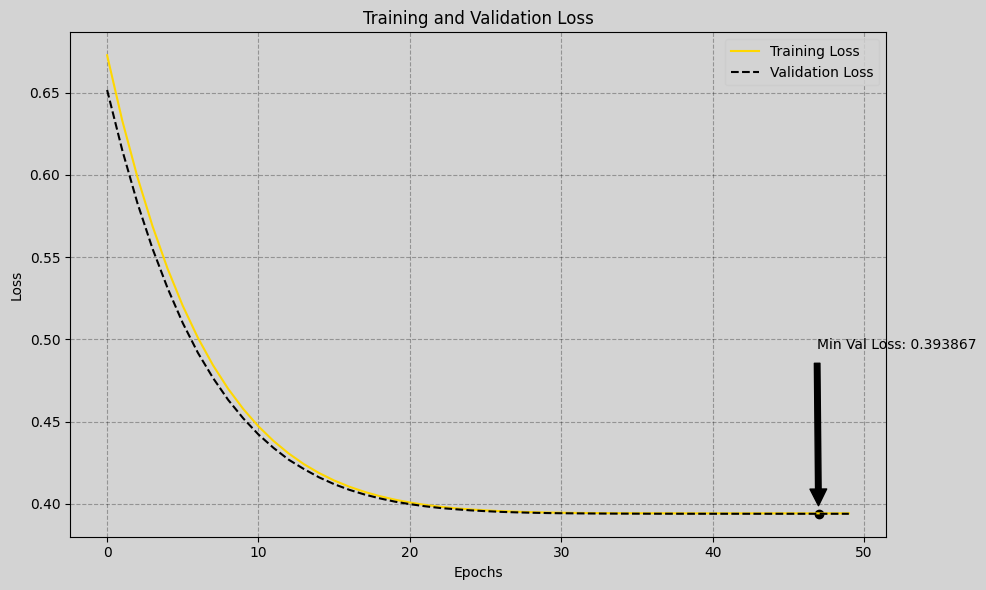

In [46]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor='lightgrey')
ax.set_facecolor('lightgrey')

ax.plot(history_rnn.history["loss"], label="Training Loss", color="gold", linestyle="-")
ax.plot(history_rnn.history["val_loss"], label="Validation Loss", color="black", linestyle="--")

ax.set_title("Training and Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

ax.grid(True, linestyle='--', alpha=0.3, color='black')

min_val_loss = min(history_rnn.history["val_loss"])
min_val_loss_epoch = history_rnn.history["val_loss"].index(min_val_loss)
ax.annotate(f'Min Val Loss: {min_val_loss:f}',
             xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch-0.1, min_val_loss+0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

ax.scatter(min_val_loss_epoch, min_val_loss, color='black', marker='o')

legend = ax.legend(loc='upper right', frameon=True)
legend.get_frame().set_facecolor('lightgrey')

plt.tight_layout()
plt.show()

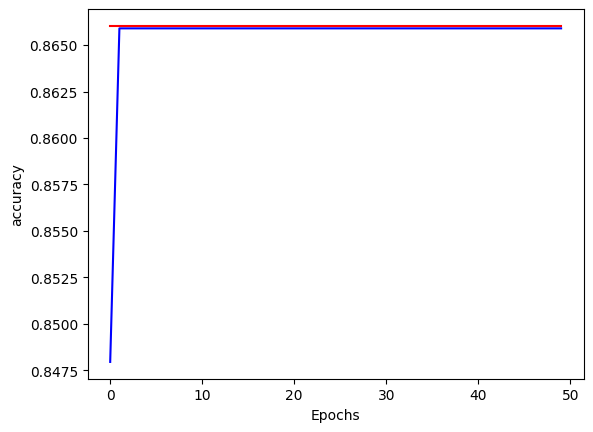

In [47]:
plt.plot(history_rnn.history["accuracy"], color="b")
plt.plot(history_rnn.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

# Simple GRU
# Modeling 👩‍🔧

In [48]:
vocab_size = tokenizer.num_words

model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 16, input_shape=(train_batch.element_spec[0].shape[1],),name="embedding"),
                  #GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=16, return_sequences=False), # returns the last output
                  #Dense(16, activation='relu'),
                  #Dense(8, activation='relu'),

                  Dense(1, activation="sigmoid")
])

In [49]:
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 74, 16)              │          16,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 16)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,665 (69.00 KB)

 Trainable params: 17,665 (69.00 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model_gru.compile(optimizer = 'adam',
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy']
                 )

In [51]:
history_gru = model_gru.fit(train_batch,
                       epochs=50,
                       validation_data = val_batch)

Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8086 - loss: 0.4896 - val_accuracy: 0.8660 - val_loss: 0.3943
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8662 - loss: 0.3950 - val_accuracy: 0.8660 - val_loss: 0.3946
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8687 - loss: 0.3899 - val_accuracy: 0.8660 - val_loss: 0.3941
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8632 - loss: 0.3998 - val_accuracy: 0.8660 - val_loss: 0.3998
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8525 - loss: 0.4246 - val_accuracy: 0.8660 - val_loss: 0.3964
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8634 - loss: 0.4005 - val_accuracy: 0.8660 - val_loss: 0.3939
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8677 - loss: 0.3914 - val_accuracy: 0.8660 - val_loss: 0.3955
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8708 - loss: 0.3868 - val_accuracy: 0.

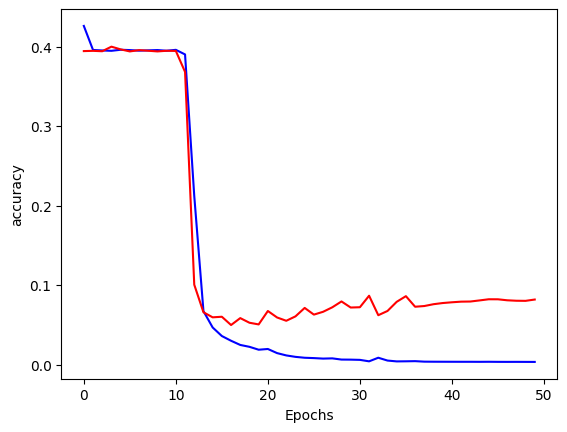

In [52]:
plt.plot(history_gru.history["loss"], color="b")
plt.plot(history_gru.history["val_loss"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

# LSTM
# Modeling 👩‍🔧

In [ ]:
vocab_size = tokenizer.num_words

model_lstm = tf.keras.Sequential([
                  Embedding(vocab_size+1, 16, input_shape=(train_batch.element_spec[0].shape[1],),name="embedding"),
                  #LSTM(units=64, return_sequences=True), # maintains the sequential nature
                  LSTM(units=16, return_sequences=False), # returns the last output
                  #Dense(16, activation='relu'),
                  #Dense(8, activation='relu'),

                  Dense(1, activation="sigmoid")
])

In [ ]:
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 16)            16016     
                                                                 
 lstm (LSTM)                 (None, 16)                2112      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 18145 (70.88 KB)
Trainable params: 18145 (70.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_lstm.compile(optimizer = 'adam',
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy']
                 )

In [ ]:
history_lstm = model_lstm.fit(train_batch,
                       epochs=50,
                       validation_data = val_batch)

Epoch 1/50
122/122 [==============================] - 6s 35ms/step - loss: 0.4465 - accuracy: 0.8659 - val_loss: 0.3949 - val_accuracy: 0.8660
Epoch 2/50
122/122 [==============================] - 4s 32ms/step - loss: 0.3951 - accuracy: 0.8659 - val_loss: 0.3939 - val_accuracy: 0.8660
Epoch 3/50
122/122 [==============================] - 3s 26ms/step - loss: 0.3956 - accuracy: 0.8659 - val_loss: 0.3971 - val_accuracy: 0.8660
Epoch 4/50
122/122 [==============================] - 4s 31ms/step - loss: 0.3952 - accuracy: 0.8659 - val_loss: 0.3944 - val_accuracy: 0.8660
Epoch 5/50
122/122 [==============================] - 4s 31ms/step - loss: 0.3947 - accuracy: 0.8659 - val_loss: 0.3941 - val_accuracy: 0.8660
Epoch 6/50
122/122 [==============================] - 3s 28ms/step - loss: 0.3951 - accuracy: 0.8659 - val_loss: 0.3939 - val_accuracy: 0.8660
Epoch 7/50
122/122 [==============================] - 3s 27ms/step - loss: 0.3945 - accuracy: 0.8659 - val_loss: 0.3941 - val_accuracy: 0.8660